# Imports

In [1]:
from time import time
import datetime
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm_notebook as tqdm
#!pip install -q git+https://github.com/oanda/oandapy.git
import oandapy as opy
from datetime import datetime as dt
from datetime import timedelta

#!pip install statsmodels
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import math
from sklearn.metrics import roc_curve
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import keras.layers as kl
from keras.callbacks import TensorBoard, EarlyStopping
%matplotlib notebook

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data

In [2]:
oanda = opy.API(environment='live')

In [3]:
# Input for downloading data using Oanda API
d1 = '2005-01-01'
d2 = str(dt.now())[:10]
instrument = 'USD_JPY'

In [4]:
# Download data in chucks
dates = pd.date_range(start=d1, end=d2, freq='D')
df = pd.DataFrame()

print('Se van a descargar {} días'.format(len(dates)))
print('Descargando:')
pbar = tqdm(total=len(dates) - 1)
for i in range(0, len(dates) - 1):
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i+1]).replace(' ', 'T')
     
    try:
        data = oanda.get_history(instrument=instrument, start=d1, end=d2, granularity='M5')
        df = df.append(pd.DataFrame(data['candles']))
        pbar.update(1)
    except:
        pass
pbar.close()
date = pd.DatetimeIndex(df['time'], tz='UTC')
df['date'] = date

Se van a descargar 5050 días
Descargando:


HBox(children=(IntProgress(value=0, max=5049), HTML(value='')))

In [5]:
DF = df.copy()

# --------------------------------------------------------------------------

In [64]:
df = DF.copy()

In [65]:
#df = pd.read_csv('USD_JPY_M5.csv', index_col=0)

In [66]:
df.head()

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume,date
0,102.59,102.49,True,102.59,102.49,102.59,102.49,102.59,102.49,2005-01-02T18:45:00.000000Z,1,2005-01-02 18:45:00+00:00
1,102.56,102.46,True,102.58,102.48,102.54,102.44,102.56,102.46,2005-01-02T18:50:00.000000Z,4,2005-01-02 18:50:00+00:00
2,102.63,102.53,True,102.63,102.53,102.63,102.53,102.63,102.53,2005-01-02T19:00:00.000000Z,3,2005-01-02 19:00:00+00:00
3,102.63,102.53,True,102.63,102.53,102.62,102.52,102.62,102.52,2005-01-02T19:05:00.000000Z,2,2005-01-02 19:05:00+00:00
4,102.61,102.51,True,102.63,102.53,102.61,102.51,102.62,102.52,2005-01-02T19:10:00.000000Z,3,2005-01-02 19:10:00+00:00


In [67]:
df = df.reset_index(drop=True)

In [68]:
df = df[150:]

In [69]:
df = df.drop(['complete', 'time'], axis=1)

In [70]:
diff = False

In [71]:
if diff:
    
    for i in [j for j in df.columns if j not in ['date', 'volume']]:
        df['diff ' + i] = df[i] - df[i].shift(1)

    drp = ['closeAsk',
           'closeBid',
           'highAsk',
           'highBid',
           'lowAsk',
           'lowBid',
           'openAsk',
           'openBid']
    df = df.drop(drp, axis=1)

    min_window = 5
    step = int(60/min_window)

    open_bid = ['diff openBid' + str(min_window*(i+1)) for i in range(step)]
    open_ask = ['diff openAsk' + str(min_window*(i+1)) for i in range(step)]
    close_bid = ['diff closeBid' + str(min_window*(i+1)) for i in range(step)]
    close_ask = ['diff closeAsk' + str(min_window*(i+1)) for i in range(step)]
    low_bid = ['diff lowBid' + str(min_window*(i+1)) for i in range(step)]
    low_ask = ['diff lowAsk' + str(min_window*(i+1)) for i in range(step)]
    high_bid = ['diff highBid' + str(min_window*(i+1)) for i in range(step)]
    high_ask = ['diff highAsk' + str(min_window*(i+1)) for i in range(step)]
    volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

    shifts = list(range(1,step+1))

    for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                 open_bid, 
                                                 open_ask, 
                                                 close_bid, 
                                                 close_ask, 
                                                 low_bid, 
                                                 low_ask, 
                                                 high_bid, 
                                                 high_ask, 
                                                 shifts):
        df[v] = df['volume'].shift(s)
        df[ob] = df['diff openBid'].shift(s)
        df[oa] = df['diff openAsk'].shift(s)
        df[cb] = df['diff closeBid'].shift(s)
        df[ca] = df['diff closeAsk'].shift(s)
        df[lb] = df['diff lowBid'].shift(s)
        df[la] = df['diff lowAsk'].shift(s)
        df[hb] = df['diff highBid'].shift(s)
        df[ha] = df['diff highAsk'].shift(s)

else:

    min_window = 5
    step = int(60/min_window)

    open_bid = ['openBid' + str(min_window*(i+1)) for i in range(step)]
    open_ask = ['openAsk' + str(min_window*(i+1)) for i in range(step)]
    close_bid = ['closeBid' + str(min_window*(i+1)) for i in range(step)]
    close_ask = ['closeAsk' + str(min_window*(i+1)) for i in range(step)]
    low_bid = ['lowBid' + str(min_window*(i+1)) for i in range(step)]
    low_ask = ['lowAsk' + str(min_window*(i+1)) for i in range(step)]
    high_bid = ['highBid' + str(min_window*(i+1)) for i in range(step)]
    high_ask = ['highAsk' + str(min_window*(i+1)) for i in range(step)]
    volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

    shifts = list(range(1,step+1))

    for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                 open_bid, 
                                                 open_ask, 
                                                 close_bid, 
                                                 close_ask, 
                                                 low_bid, 
                                                 low_ask, 
                                                 high_bid, 
                                                 high_ask, 
                                                 shifts):
        df[v] = df['volume'].shift(s)
        df[ob] = df['openBid'].shift(s)
        df[oa] = df['openAsk'].shift(s)
        df[cb] = df['closeBid'].shift(s)
        df[ca] = df['closeAsk'].shift(s)
        df[lb] = df['lowBid'].shift(s)
        df[la] = df['lowAsk'].shift(s)
        df[hb] = df['highBid'].shift(s)
        df[ha] = df['highAsk'].shift(s)
    

In [72]:
df = df[13:]

In [73]:
df['date'] = df['date'].astype(str)

In [74]:
df['d2'] = df['date'].str[14:]

In [75]:
df = df[df['d2'] == '00:00+00:00']

In [76]:
fake_drop = volume + ['volume', 'date', 'd2']
df['H'] = df.drop(fake_drop, 1).max(axis=1)
df['L'] = df.drop(fake_drop, 1).min(axis=1)
df['vol'] = df[volume].sum(axis=1)

In [77]:
drop = ['d2']
df = df.drop(drop, axis=1)

# Twitter

In [78]:
import psycopg2
import logging
import os

def db_conn():
    """
    Método que hace la conexión a la base de datos
    Args:
        conn_creds(dict): diccionario donde vienen las credenciales de
        la conexión a la base de datos
                         host(str): host que hospeda a la base de datos
                         port(str): puerto donde está disponible la base de datos
                         user(str): usuario con el que se hará la conexión
                         password(str): contraseña del usuario en la BD
                         database(str): nombre de la base de datos
    Returns:
        conn: objeto que contiene la sesión de una conexión a la BD
    """
    try:
        conn = psycopg2.connect(
            host=os.environ['ID_HOST'],
            port=os.environ['ID_PORT'],
            user=os.environ['ID_USER'],
            password=os.environ['ID_PASSWORD'],
            database=os.environ['ID_DB'],
        )
    except Exception as error:
        logging.error(error)

    return conn

def download(conn, query):
    """
    Descarga datos de la base de datos según la consulta insertada
    Args:
        conn (connection): objeto que contiene la sesión de una
                           conexión a la base de datos
        query (str): String donde se define el query a ejecutarse
    Returns:
        df (DataFrame): Tabla con los datos que elegimos
    """
    try:
        df = pd.read_sql(query, conn)
        conn.commit()
    finally:
        conn.close()


    return df

In [79]:
conn = db_conn()
query = '''SELECT date_trunc('hour',cast(date as timestamp)), avg(polarity) polarity, avg(subjectivity) subjectivity
           FROM tweets GROUP BY date_trunc('hour',cast(date as timestamp))'''
tw = download(conn, query)

In [80]:
tw['date_trunc'] = tw['date_trunc'] + timedelta(hours=5)

# JOIN

In [81]:
df['date'] = df['date'].str[:13]

In [82]:
tw['date_trunc'] = tw['date_trunc'].astype(str)
tw['date_trunc'] = tw['date_trunc'].str[:13]

In [83]:
df = pd.merge(df, tw, left_on='date', right_on='date_trunc', how='left')

In [86]:
df = df.drop(['date', 'date_trunc'], axis=1)

In [87]:
df.head()

,closeAsk,closeBid,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume,volume5,openBid5,openAsk5,closeBid5,closeAsk5,lowBid5,lowAsk5,highBid5,highAsk5,volume10,openBid10,openAsk10,closeBid10,closeAsk10,lowBid10,lowAsk10,highBid10,highAsk10,volume15,openBid15,openAsk15,closeBid15,closeAsk15,lowBid15,lowAsk15,highBid15,highAsk15,volume20,openBid20,openAsk20,closeBid20,closeAsk20,lowBid20,lowAsk20,highBid20,highAsk20,volume25,openBid25,openAsk25,closeBid25,closeAsk25,lowBid25,lowAsk25,highBid25,highAsk25,volume30,openBid30,openAsk30,closeBid30,closeAsk30,lowBid30,lowAsk30,highBid30,highAsk30,volume35,openBid35,openAsk35,closeBid35,closeAsk35,lowBid35,lowAsk35,highBid35,highAsk35,volume40,openBid40,openAsk40,closeBid40,closeAsk40,lowBid40,lowAsk40,highBid40,highAsk40,volume45,openBid45,openAsk45,closeBid45,closeAsk45,lowBid45,lowAsk45,highBid45,highAsk45,volume50,openBid50,openAsk50,closeBid50,closeAsk50,lowBid50,lowAsk50,highBid50,highAsk50,volume55,openBid55,openAsk55,closeBid55,closeAsk55,lowBid55,lowAsk55,highBid55,highAsk55,volume60,openBid60,openAsk60,closeBid60,closeAsk60,lowBid60,lowAsk60,highBid60,highAsk60,H,L,vol,polarity,subjectivity
0,102.79,102.76,102.79,102.76,102.70,102.67,102.70,102.67,140,147.0,102.70,102.73,102.67,102.70,102.65,102.68,102.70,102.73,72.0,102.73,102.76,102.70,102.73,102.70,102.73,102.73,102.76,105.0,102.74,102.77,102.73,102.76,102.72,102.75,102.75,102.78,138.0,102.69,102.72,102.74,102.77,102.68,102.71,102.77,102.80,132.0,102.72,102.75,102.69,102.72,102.65,102.68,102.75,102.78,157.0,102.73,102.76,102.72,102.75,102.70,102.73,102.74,102.77,162.0,102.81,102.84,102.73,102.76,102.73,102.76,102.82,102.85,177.0,102.78,102.81,102.81,102.84,102.77,102.80,102.85,102.88,140.0,102.75,102.78,102.78,102.81,102.74,102.77,102.80,102.83,163.0,102.70,102.73,102.74,102.77,102.69,102.72,102.74,102.77,193.0,102.70,102.73,102.70,102.73,102.67,102.70,102.74,102.77,179.0,102.74,102.77,102.70,102.73,102.69,102.72,102.75,102.78,102.88,102.65,1765.0,NaN,NaN
1,102.74,102.71,102.75,102.72,102.73,102.70,102.75,102.72,86,136.0,102.69,102.72,102.73,102.76,102.68,102.71,102.76,102.79,119.0,102.67,102.70,102.70,102.73,102.65,102.68,102.71,102.74,178.0,102.71,102.74,102.67,102.70,102.62,102.65,102.71,102.74,179.0,102.73,102.76,102.71,102.74,102.69,102.72,102.76,102.79,180.0,102.58,102.61,102.73,102.76,102.57,102.60,102.73,102.76,197.0,102.50,102.53,102.57,102.60,102.50,102.53,102.60,102.63,234.0,102.69,102.72,102.50,102.53,102.48,102.51,102.70,102.73,181.0,102.74,102.77,102.69,102.72,102.67,102.70,102.77,102.80,184.0,102.68,102.71,102.74,102.77,102.68,102.71,102.76,102.79,125.0,102.74,102.77,102.68,102.71,102.67,102.70,102.75,102.78,132.0,102.76,102.79,102.74,102.77,102.71,102.74,102.77,102.80,140.0,102.67,102.70,102.76,102.79,102.67,102.70,102.76,102.79,102.80,102.48,1985.0,NaN,NaN
2,102.73,102.70,102.77,102.74,102.71,102.68,102.72,102.69,158,136.0,102.68,102.71,102.69,102.72,102.65,102.68,102.71,102.74,116.0,102.67,102.70,102.68,102.71,102.66,102.69,102.71,102.74,107.0,102.69,102.72,102.67,102.70,102.65,102.68,102.69,102.72,134.0,102.68,102.71,102.69,102.72,102.67,102.70,102.70,102.73,156.0,102.74,102.77,102.68,102.71,102.67,102.70,102.74,102.77,128.0,102.67,102.70,102.74,102.77,102.67,102.70,102.76,102.79,77.0,102.69,102.72,102.67,102.70,102.66,102.69,102.69,102.72,112.0,102.64,102.67,102.69,102.72,102.63,102.66,102.70,102.73,87.0,102.66,102.69,102.64,102.67,102.62,102.65,102.66,102.69,98.0,102.66,102.69,102.66,102.69,102.64,102.67,102.67,102.70,125.0,102.70,102.73,102.65,102.68,102.65,102.68,102.71,102.74,86.0,102.72,102.75,102.71,102.74,102.70,102.73,102.72,102.75,102.79,102.62,1362.0,NaN,NaN
3,102.82,102.79,102.84,102.81,102.78,102.75,102.80,102.77,137,177.0,102.76,102.79,102.77,102.80,102.73,102.76,102.80,102.83,128.0,102.73,102.76,102.76,102.79,102.69,102.72,102.76,102.79,102.0,102.68,102.71,102.73,102.76,102.68,102.71,102.74,102.77,15.0,102.69,102.72,102.68,102.71,102.68,102.71,102.69,102.72,86.0,102.69,102.72,102.69,102.7

In [88]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

In [89]:
df.to_csv('data_precios.csv')

In [90]:
def train_test(Data, response, time_series=False):
    """
    Regresa train y test sets con el 75% de los datos
    para entrenar y el 25% para probar el modelo
    
    Args:
        Data (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        time_series (boolean): Si es serie de tiempo o no
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
        
    """
    
    Data1 = Data.copy()
    X = Data1.drop(response, 1)
    y = Data1[response]
    print('X Variables: ')
    print(X.columns)
    print('\nResponse:')
    print(response)
    
    if time_series:
        tscv = TimeSeriesSplit(n_splits=2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
    
    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

def simple_model(X_train, y_train, tpot=False):
    """
    Obtiene variable objetivo, decide si es de clasificación o regresión
    y regresa un modelo simple
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
        tpot (boolean): si queremos generar modelo con tpot
    Returns:
        model (modelo): Regresión Logística o Lineal dependiendo de la variable
                         objetivo
        tpotmod (modelo): Modelo de Regresión o Clasificación generado con TPOT
    """
    tpotm = None
    # Revisamos si es modelo de clasificación binaria
    if len(set(np.unique(y_train))) == 2:
        model = logreg(X_train, y_train)
        if tpot:
            toptm = tpotclass(X_train, y_train)
    elif len(set(np.unique(y_train))) > 2 and len(set(np.unique(y_train))) < 10:
        multilog = sm.MNLogit(y_train, X_train)
        model = multilog.fit()
        if tpot:
            tpotm = tpotclass(X_train, y_train)
    else:
        model = linreg(X_train, y_train)
        if tpot:
            tpotm = tpotreg(X_train, y_train)

    return model, tpotm


  
def rnn_reg(X_train, y_train, bs=1024, epcs=100):
  
    model = Sequential()

    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    model.add(Dense(activation="linear", units=1))

    model.compile(loss ="mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error", "accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), 
                              histogram_freq=0, 
                              batch_size=bs, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=False, 
                              update_freq='epoch')
    
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=1,
                                   mode='auto',
                                   restore_best_weights=True)
    
    model.fit(X_train, y_train, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.25, callbacks=[tensorboard, early_stopping])
   
    return model

def rnn_class(X_train, y_train, bs=1024, epcs=5):
    
    model = Sequential()
    
    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    
    model.add(Dense(activation="sigmoid", units=1))

    model.compile(loss ="binary_crossentropy" , optimizer = "adam", metrics = ["accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), histogram_freq=0, batch_size=bs, write_graph=True, write_grads=False, write_images=False, update_freq='epoch')
    model.fit(X_train, y_train, shuffle = False, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.05, callbacks=[tensorboard])
   
    return model

def model_precision(y_test, predictions, lim):
    """
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
        lim (float): Entre 0 y 1 que marca el límite de clasificación (arriba de lim se considera cierre)
    
    Returns:
        Accuracy (float): (tp+tn)/(tp+tn+fp+fn)
        Precision (float): tp/(tp+fp)
        Recall (float): tp/(tp+fn)
        F1_score (float): 2/(1/Precision+1/Recall) Media armónica entre Precision y Recall
        MCC (float): Matthiews Correlation Coefficient (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    
    """
          
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test, predictions),axis=1)

    tp = ((test[:,0] == 1) & (test[:,1] >= lim)).sum()
    fp = ((test[:,0] == 0) & (test[:,1] >= lim)).sum()
    tn = ((test[:,0] == 0) & (test[:,1] < lim)).sum()
    fn = ((test[:,0] == 1) & (test[:,1] < lim)).sum()
    
    Accuracy = (tp+tn)/(tp+tn+fp+fn)
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1_score = 2/(1/Precision+1/Recall)
    MCC = (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    

    res = pd.DataFrame(0, index=['Accuracy', 'Precision',
                                     'Recall', 'F1 Score',
                                     'MCC'], columns=['Score'])

    res.loc['Accuracy'] = 100*Accuracy
    res.loc['Precision'] = 100*Precision
    res.loc['Recall'] = 100*Recall
    res.loc['F1 Score'] = 100*F1_score
    res.loc['MCC'] = 100*MCC
    display(res)
    
    return Accuracy, Precision, Recall, F1_score, MCC

def bucket_scores(y_test, predictions):
    """
    Precision por cubeta de 10 en 10
    
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
    
    Returns:
        res (DataFrame): Positive rate por scores de 1 a 100 en cubetas de 10
    
    """
    scoresindex = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
    scorescolumns = ['Total','Positives']
    res = pd.DataFrame(0, index=scoresindex, columns=scorescolumns)
    
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test,predictions),axis=1)
    
    low = 0
    up = 0.1
    for i in scoresindex:
        res.loc[i]['Total'] = ((test[:,1] >= low) & (test[:,1] < up)).sum()
        res.loc[i]['Positives'] = ((test[:,1] >= low) & (test[:,1] < up) & (test[:,0] == 1)).sum()
        low += 0.1
        up += 0.1
    res['Positive Rate'] = res['Positives']/res['Total']*100  
    
    return res

# Price

## Future Close (price)

X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume', 'volume5',
       ...
       'closeAsk60', 'lowBid60', 'lowAsk60', 'highBid60', 'highAsk60', 'H',
       'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future CloseBid


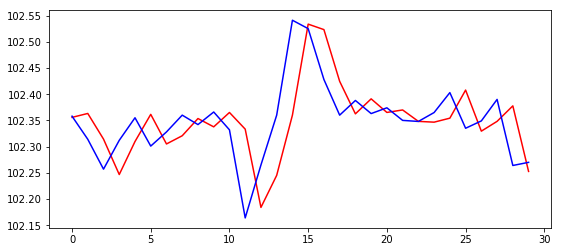

In [91]:
df_fc = df.copy()

#df_fc = (df_fc - df_fc.mean()) / (df_fc.max() - df_fc.min())

if diff:

    response = 'Future diff CloseBid'
    actual = 'diff closeBid'
else:
    response = 'Future CloseBid'
    actual = 'closeBid'
#
df_fc[response] = df_fc[actual].shift(-1)

df_fc = df_fc.dropna()

X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(9,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

#nn_fc = rnn_reg(X_train, y_train)
#print(nn_fc.summary())
#plt.figure(figsize=(9,4))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
#plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
#plt.show()

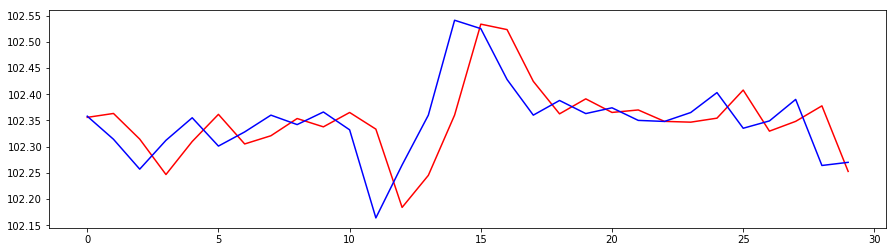

In [92]:
## LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

#nn_fc = rnn_reg(X_train, y_train, bs=512, epcs=25)
#print(nn_fc.summary())
#plt.figure(figsize=(15,4))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
#plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
#plt.show()

# Future High (price)

X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume', 'volume5',
       ...
       'closeAsk60', 'lowBid60', 'lowAsk60', 'highBid60', 'highAsk60', 'H',
       'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future highBid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.663e+08
Date:                Mon, 29 Oct 2018   Prob (F-statistic):               0.00
Time:                        13:59:13   Log-Likelihood:                 34540.
No. Observations:               58032   AIC:                        -6.884e+04
Df Residuals:                   57911   BIC:                        -6.775e+04
Df Model:                         12

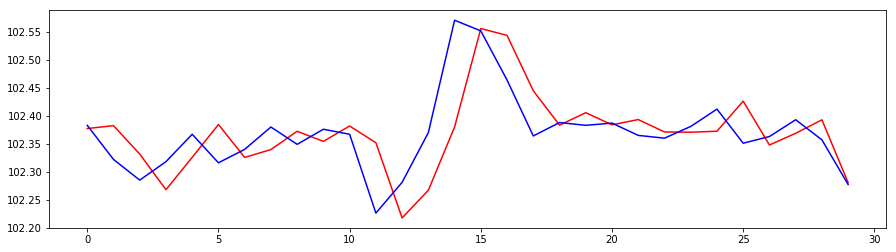

In [93]:
df_fh = df.copy()

if diff:

    response = 'Future diff highBid'
    actual = 'diff highBid'

else:
    response = 'Future highBid'
    actual = 'highBid'
    
df_fh[response] = df_fh[actual].shift(-1)

df_fh = df_fh.dropna()

X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LINREG (price)

lr_fh = linreg(X_train, y_train)
print(lr_fh.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

#nn_fh = rnn_reg(X_train, y_train, bs=512, epcs=5)
#print(nn_fh.summary())
#plt.figure(figsize=(15,4))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#plt.plot(range(len(y_test[:30])),nn_fh.predict(X_test[:30]), color='r')
#plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
#plt.show()

# Future Low (price)

X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume', 'volume5',
       ...
       'closeAsk60', 'lowBid60', 'lowAsk60', 'highBid60', 'highAsk60', 'H',
       'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future lowBid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.557e+08
Date:                Mon, 29 Oct 2018   Prob (F-statistic):               0.00
Time:                        13:59:17   Log-Likelihood:                 33390.
No. Observations:               58032   AIC:                        -6.654e+04
Df Residuals:                   57911   BIC:                        -6.545e+04
Df Model:                         121

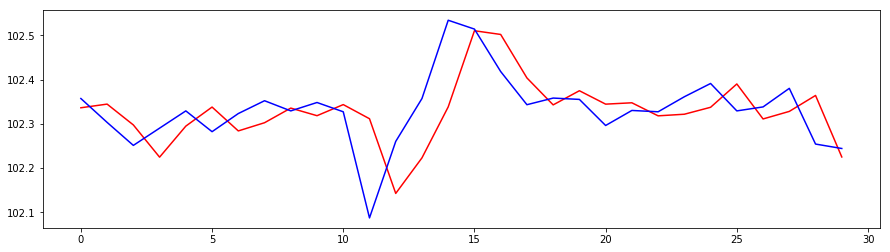

In [94]:
df_fl = df.copy()

if diff:
    response = 'Future diff lowBid'

    actual = 'diff lowBid'
else:
    response = 'Future lowBid'
    actual = 'lowBid'

df_fl[response] = df_fl[actual].shift(-1)

df_fl = df_fl.dropna()

X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LINREG (price)

lr_fl = linreg(X_train, y_train)
print(lr_fl.summary())
plt.figure(figsize=(15,4))#
plt.plot(range(len(y_test[:30])),lr_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

#nn_fl = rnn_reg(X_train, y_train, bs=512, epcs=5)
#print(nn_fl.summary())
#plt.figure(figsize=(15,4))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#plt.plot(range(len(y_test[:30])),nn_fl.predict(X_test[:30]), color='r')
#plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
#plt.show()

# Score

## Future Close (higher)

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff closeAsk60', 'diff lowBid60', 'diff lowAsk60', 'diff highBid60',
       'diff highAsk60', 'H', 'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future close higher
LOGREG


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
Singular matrix


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:229: RuntimeWarning: invalid value encountered in true_divide


,Score
Accuracy,50.902806
Precision,50.902806
Recall,100.000000
F1 Score,67.464360
MCC,NaN


,Total,Positives,Positive Rate
0-10,0,0,NaN
10-20,0,0,NaN
20-30,0,0,NaN
30-40,0,0,NaN
40-50,0,0,NaN
50-60,24590,12517,50.902806
60-70,0,0,NaN
70-80,0,0,NaN
80-90,0,0,NaN
90-100,0,0,NaN


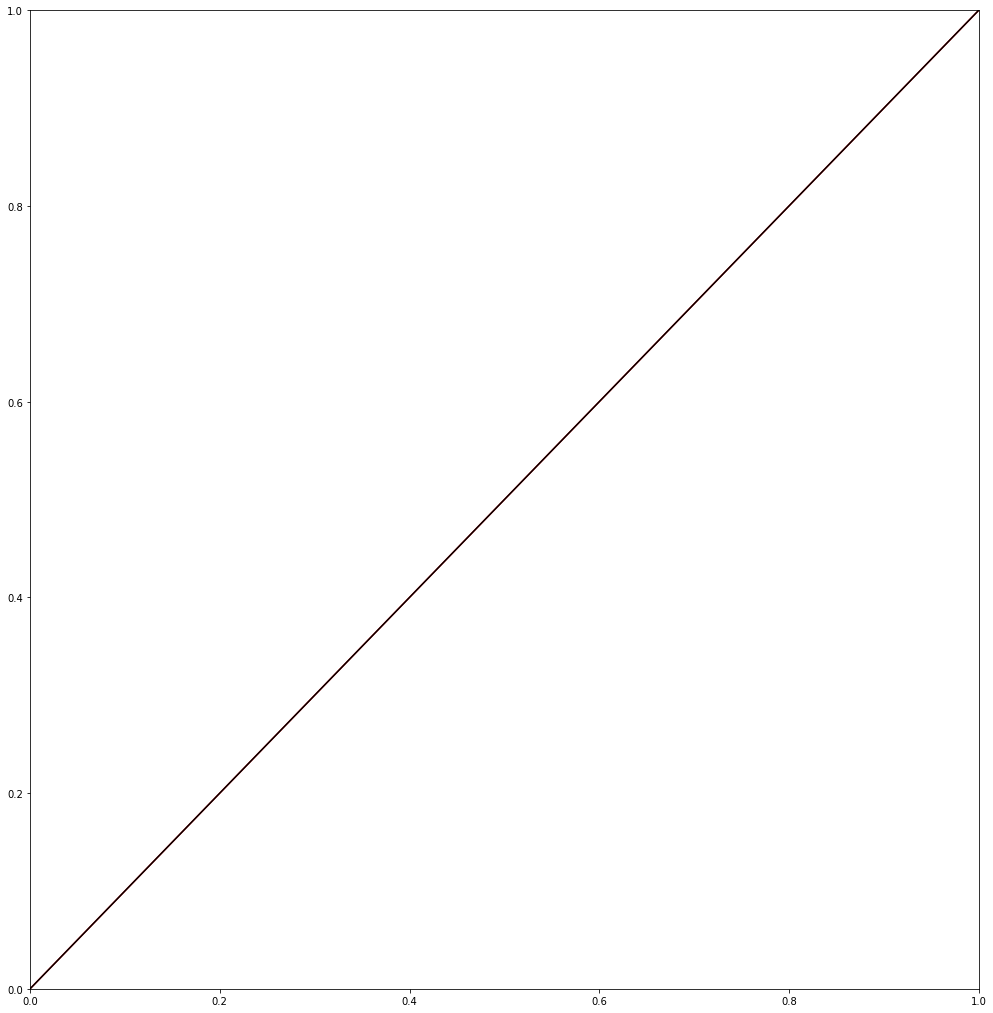

In [39]:
dfc_fc = df.copy()
actual = 'diff closeBid'
response = 'Future close higher'
lim = 0.5
dfc_fc[response] = 0
dfc_fc.loc[dfc_fc[actual] >= 0, response] = 1
dfc_fc[response] = dfc_fc[response].shift(-1)
dfc_fc = dfc_fc.dropna()
X_train, X_test, y_train, y_test = train_test(dfc_fc, response, time_series=True)

### LOGREG
print('LOGREG')
logr_fc = logreg(X_train, y_train)
predictions = logr_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
#print('RNN CLASS')
#nn_fc = rnn_class(X_train, y_train, bs=512, epcs=20)
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#predictions = nn_fc.predict(X_test)
#model_precision(y_test, predictions, lim)
#bs = bucket_scores(y_test, predictions)
#display(bs)

#fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
#plt.plot(fpr, tpr, 'b')

plt.show()

## Future High (higher)

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff closeAsk60', 'diff lowBid60', 'diff lowAsk60', 'diff highBid60',
       'diff highAsk60', 'H', 'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future high higher
LOGREG


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
Singular matrix
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:229: RuntimeWarning: invalid value encountered in true_divide


,Score
Accuracy,52.411549
Precision,52.411549
Recall,100.000000
F1 Score,68.776349
MCC,NaN


,Total,Positives,Positive Rate
0-10,0,0,NaN
10-20,0,0,NaN
20-30,0,0,NaN
30-40,0,0,NaN
40-50,0,0,NaN
50-60,24590,12888,52.411549
60-70,0,0,NaN
70-80,0,0,NaN
80-90,0,0,NaN
90-100,0,0,NaN


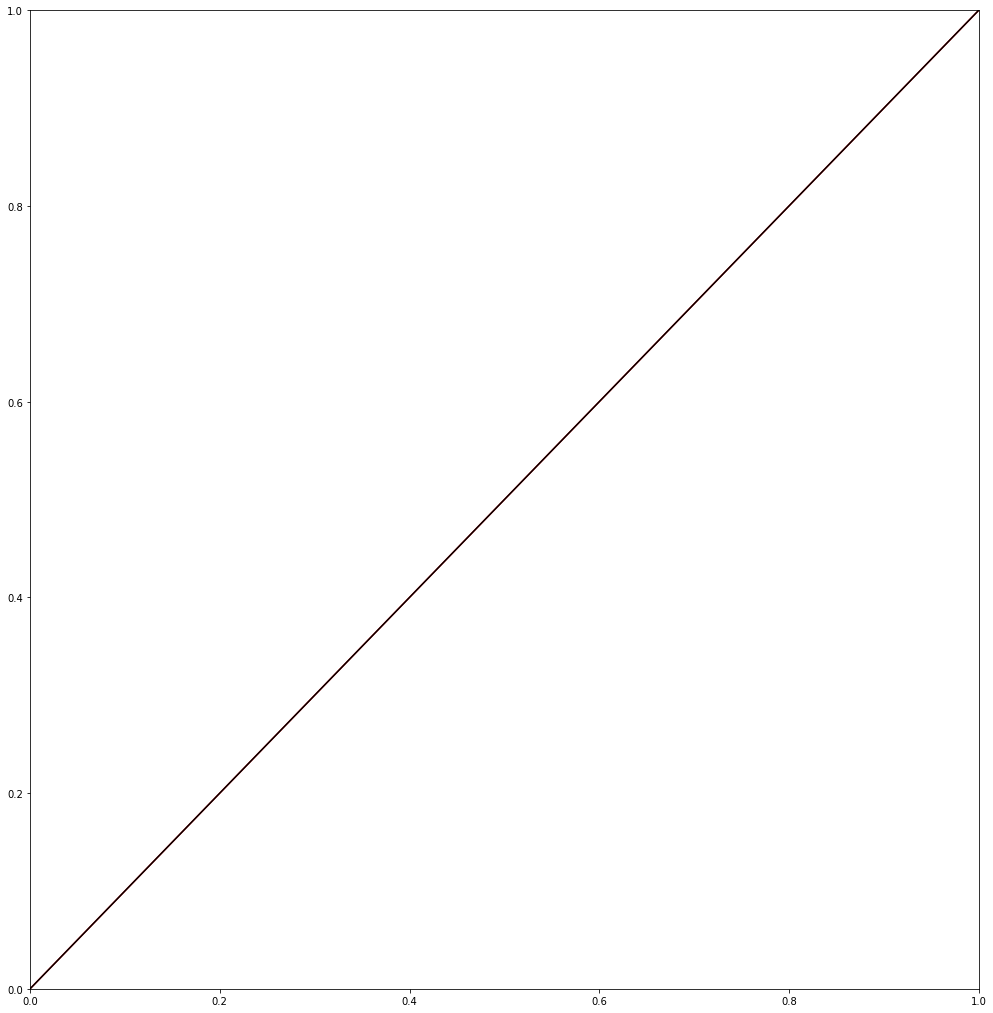

In [40]:
dfc_fh = df.copy()
actual = 'diff highBid'
response = 'Future high higher'
lim = 0.5
dfc_fh[response] = 0
dfc_fh.loc[dfc_fh[actual] >= 0, response] = 1
dfc_fh[response] = dfc_fh[response].shift(-1)
dfc_fh = dfc_fh.dropna()
X_train, X_test, y_train, y_test = train_test(dfc_fh, response, time_series=True)

### LOGREG
print('LOGREG')
logr_fh = logreg(X_train, y_train)
predictions = logr_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
#print('RNN CLASS')
#nn_fh = rnn_class(X_train, y_train, bs=512, epcs=20)
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#predictions = nn_fh.predict(X_test)
#model_precision(y_test, predictions, lim)
#bs = bucket_scores(y_test, predictions)
#display(bs)

#fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
#plt.plot(fpr, tpr, 'b')

plt.show()

## Future Low (higher)

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff closeAsk60', 'diff lowBid60', 'diff lowAsk60', 'diff highBid60',
       'diff highAsk60', 'H', 'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future low higher
LOGREG


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
Singular matrix
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:229: RuntimeWarning: invalid value encountered in true_divide


,Score
Accuracy,49.934933
Precision,49.934933
Recall,100.000000
F1 Score,66.608804
MCC,NaN


,Total,Positives,Positive Rate
0-10,0,0,NaN
10-20,0,0,NaN
20-30,0,0,NaN
30-40,0,0,NaN
40-50,0,0,NaN
50-60,24590,12279,49.934933
60-70,0,0,NaN
70-80,0,0,NaN
80-90,0,0,NaN
90-100,0,0,NaN


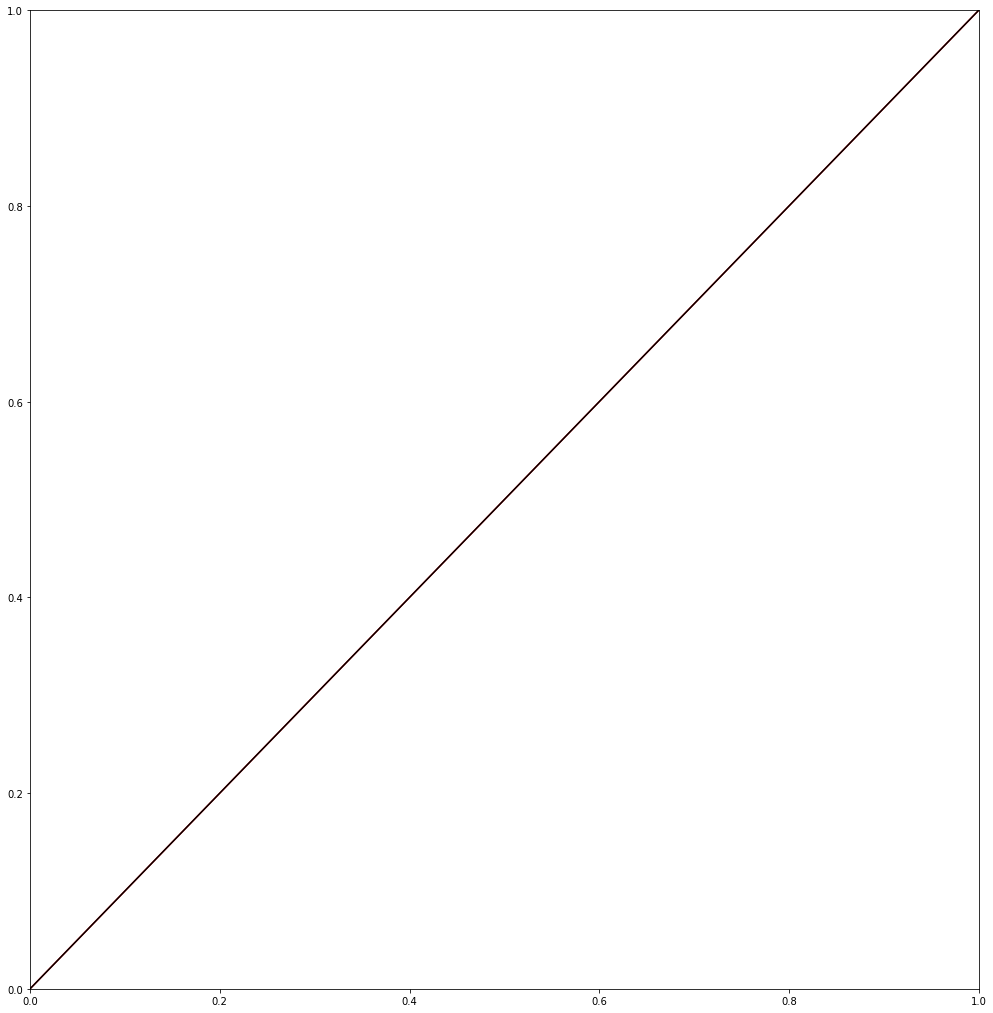

In [41]:
dfc_fl = df.copy()
actual = 'diff lowBid'
response = 'Future low higher'
lim = 0.5
dfc_fl[response] = 0
dfc_fl.loc[dfc_fl[actual] >= 0, response] = 1
dfc_fl[response] = dfc_fl[response].shift(-1)
dfc_fl = dfc_fl.dropna()
X_train, X_test, y_train, y_test = train_test(dfc_fl, response, time_series=True)

### LOGREG
print('LOGREG')
logr_fl = logreg(X_train, y_train)
predictions = logr_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
#print('RNN CLASS')
#nn_fl = rnn_class(X_train, y_train, bs=512, epcs=20)
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#predictions = nn_fl.predict(X_test)
#model_precision(y_test, predictions, lim)
#bs = bucket_scores(y_test, predictions)
#display(bs)

#fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
#plt.plot(fpr, tpr, 'b')

plt.show()

# Backtesting

In [145]:
if diff:

    X_train_fc, X_test_fc, y_train_fc, y_test_fc = train_test(df_fc, 'Future diff CloseBid', time_series=True)
    X_train_fh, X_test_fh, y_train_fh, y_test_fh = train_test(df_fh, 'Future diff highBid', time_series=True)
    X_train_fl, X_test_fl, y_train_fl, y_test_fl = train_test(df_fl, 'Future diff lowBid', time_series=True)

    X_trainc_fc, X_testc_fc, y_trainc_fc, y_testc_fc = train_test(dfc_fc, 'Future close higher', time_series=True)
    X_trainc_fh, X_testc_fh, y_trainc_fh, y_testc_fh = train_test(dfc_fh, 'Future high higher', time_series=True)
    X_trainc_fl, X_testc_fl, y_trainc_fl, y_testc_fl = train_test(dfc_fl, 'Future low higher', time_series=True)


    fc = lr_fc.predict(X_test_fc)
    fh = lr_fh.predict(X_test_fh)
    fl = lr_fl.predict(X_test_fl)

    fcc = logr_fc.predict(X_testc_fc)
    fhc = logr_fh.predict(X_testc_fh)
    flc = logr_fl.predict(X_testc_fl)

    bt = pd.DataFrame({'Expected Close Change': y_test_fc, 
                       'Predicted Close Change': fc, 
                       'Expected High Change': y_test_fh, 
                       'Predicted High Change': fh,
                       'Expected Low Change': y_test_fl,
                       'Predicted Low Change': fl,
                       'Expected close class': y_testc_fc, 
                       'Predicted close class': fcc,
                       'Expected high class': y_testc_fh,
                       'Predicted high class': fhc, 
                       'Expected low class': y_testc_fl, 
                       'Predicted low class': flc})
    bt = bt[['Expected Close Change', 
           'Predicted Close Change', 
           'Expected High Change', 
           'Predicted High Change',
           'Expected Low Change',
           'Predicted Low Change',
           'Expected close class', 
           'Predicted close class',
           'Expected high class',
           'Predicted high class', 
           'Expected low class', 
           'Predicted low class']] 

    bt.loc[bt['Predicted close class'] < 0.5, 'Predicted close class'] = 0
    bt.loc[bt['Predicted close class'] >= 0.5, 'Predicted close class'] = 1
    bt.loc[bt['Predicted high class'] < 0.5, 'Predicted high class'] = 0
    bt.loc[bt['Predicted high class'] >= 0.5, 'Predicted high class'] = 1
    bt.loc[bt['Predicted low class'] < 0.5, 'Predicted low class'] = 0
    bt.loc[bt['Predicted low class'] >= 0.5, 'Predicted low class'] = 1

    errorbt = bt[bt.columns[:6]]

    errorbt.columns = ['Close Change Error',
                       'Close Change Correct Mov',
                       'High Change Error',
                       'High Change Correct Mov',
                       'Low Change Error',
                       'Low Change Correct Mov']

    errorbt['Close Change Error'] = abs(bt['Expected Close Change'] - bt['Predicted Close Change'])
    errorbt['Close Change Correct Mov'] = bt['Expected Close Change']*bt['Predicted Close Change'] >= 0
    errorbt['High Change Error'] = abs(bt['Expected High Change'] - bt['Predicted High Change'])
    errorbt['High Change Correct Mov'] = bt['Expected High Change']*bt['Predicted High Change'] >= 0
    errorbt['Low Change Error'] = abs(bt['Expected Low Change'] - bt['Predicted Low Change'])
    errorbt['Low Change Correct Mov'] = bt['Expected Low Change']*bt['Predicted Low Change'] >= 0
    
else:
    X_train_fc, X_test_fc, y_train_fc, y_test_fc = train_test(df_fc, 'Future CloseBid', time_series=True)
    X_train_fh, X_test_fh, y_train_fh, y_test_fh = train_test(df_fh, 'Future highBid', time_series=True)
    X_train_fl, X_test_fl, y_train_fl, y_test_fl = train_test(df_fl, 'Future lowBid', time_series=True)

    X_trainc_fc, X_testc_fc, y_trainc_fc, y_testc_fc = train_test(dfc_fc, 'Future close higher', time_series=True)
    X_trainc_fh, X_testc_fh, y_trainc_fh, y_testc_fh = train_test(dfc_fh, 'Future high higher', time_series=True)
    X_trainc_fl, X_testc_fl, y_trainc_fl, y_testc_fl = train_test(dfc_fl, 'Future low higher', time_series=True)


    fc = lr_fc.predict(X_test_fc)
    fh = lr_fh.predict(X_test_fh)
    fl = lr_fl.predict(X_test_fl)

    #fcc = logr_fc.predict(X_testc_fc)
    #fhc = logr_fh.predict(X_testc_fh)
    #flc = logr_fl.predict(X_testc_fl)

    bt = pd.DataFrame({'Expected Close': y_test_fc, 
                       'Predicted Close': fc, 
                       'Expected High': y_test_fh, 
                       'Predicted High': fh,
                       'Expected Low': y_test_fl,
                       'Predicted Low': fl})
                       #'Expected close class': y_testc_fc, 
                       #'Predicted close class': fcc,
                       #'Expected high class': y_testc_fh,
                       #'Predicted high class': fhc, 
                       #'Expected low class': y_testc_fl, 
                       #'Predicted low class': flc})
    bt = bt[['Expected Close', 
           'Predicted Close', 
           'Expected High', 
           'Predicted High',
           'Expected Low',
           'Predicted Low']]
           #'Expected close class', 
           #'Predicted close class',
           #'Expected high class',
           #'Predicted high class', 
           #'Expected low class', 
           #'Predicted low class']] 

    #bt.loc[bt['Predicted close class'] < 0.5, 'Predicted close class'] = 0
    #bt.loc[bt['Predicted close class'] >= 0.5, 'Predicted close class'] = 1
    #bt.loc[bt['Predicted high class'] < 0.5, 'Predicted high class'] = 0
    #bt.loc[bt['Predicted high class'] >= 0.5, 'Predicted high class'] = 1
    #bt.loc[bt['Predicted low class'] < 0.5, 'Predicted low class'] = 0
    #bt.loc[bt['Predicted low class'] >= 0.5, 'Predicted low class'] = 1

    errorbt = bt[bt.columns[:6]]

    errorbt.columns = ['Close Error',
                       'Close Correct Mov',
                       'High Error',
                       'High Correct Mov',
                       'Low Error',
                       'Low Correct Mov']
#####
    errorbt['Close Error'] = abs(bt['Expected Close'] - bt['Predicted Close'])
    errorbt['Close Correct Mov'] = (((bt['Expected Close'] >= bt['Expected Close'].shift(1)) \
                                   & (bt['Predicted Close'] >= bt['Expected Close'].shift(1)))
                                   | ((bt['Expected Close'] < bt['Expected Close'].shift(1)) \
                                   & (bt['Predicted Close'] < bt['Expected Close'].shift(1))))
    errorbt['High Error'] = abs(bt['Expected High'] - bt['Predicted High'])
    errorbt['High Correct Mov'] = (((bt['Expected High'] >= bt['Expected High'].shift(1)) \
                                   & (bt['Predicted High'] >= bt['Expected High'].shift(1)))
                                   | ((bt['Expected High'] < bt['Expected High'].shift(1)) \
                                   & (bt['Predicted High'] < bt['Expected High'].shift(1))))
    errorbt['Low Error'] = abs(bt['Expected Low'] - bt['Predicted Low'])
    errorbt['Low Correct Mov'] = (((bt['Expected Low'] >= bt['Expected Low'].shift(1)) \
                                   & (bt['Predicted Low'] >= bt['Expected Low'].shift(1)))
                                   | ((bt['Expected Low'] < bt['Expected Low'].shift(1)) \
                                   & (bt['Predicted Low'] < bt['Expected Low'].shift(1))))

X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume', 'volume5',
       ...
       'closeAsk60', 'lowBid60', 'lowAsk60', 'highBid60', 'highAsk60', 'H',
       'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future CloseBid
X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume', 'volume5',
       ...
       'closeAsk60', 'lowBid60', 'lowAsk60', 'highBid60', 'highAsk60', 'H',
       'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future highBid
X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume', 'volume5',
       ...
       'closeAsk60', 'lowBid60', 'lowAsk60', 'highBid60', 'highAsk60', 'H',
       'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future lowBid
X Va

In [146]:
for i in bt.columns:
    bt[i] = round(bt[i], 3)
bt['win high'] = bt['Predicted High'] - 0.02 < bt['Expected High']
bt['win low'] = bt['Predicted Low'] + 0.02 > bt['Expected Low'] 

In [156]:
bt['win change high'] = 0
bt.loc[(bt['win high']), 'win change high'] = round(bt['Predicted High'] - 0.02 - bt['Expected Close'].shift(1), 4)
bt.loc[(bt['win high'] != True), 'win change high'] = round(bt['Expected Close'].shift(1) - bt['Predicted Low'] - 0.02, 4)
bt['win change low'] = 0
bt.loc[(bt['win low']), 'win change low'] = round(bt['Expected Close'].shift(1) - bt['Predicted Low'] + 0.02, 4)
bt.loc[(bt['win low'] != True), 'win change low'] = round(bt['Expected Close'].shift(1) - bt['Predicted High'] + 0.02, 4)
bt = bt.dropna()

In [157]:
bt

,Expected Close,Predicted Close,Expected High,Predicted High,Expected Low,Predicted Low,win high,win low,win change high,win change low
3,102.312,102.247,102.318,102.268,102.290,102.224,True,False,-0.009,0.009
4,102.355,102.310,102.367,102.326,102.329,102.295,True,False,-0.006,0.006
5,102.301,102.362,102.316,102.384,102.282,102.338,False,True,-0.003,0.037
6,102.328,102.305,102.340,102.326,102.323,102.284,True,False,0.005,-0.005
7,102.360,102.321,102.380,102.340,102.352,102.302,True,False,-0.008,0.008
8,102.342,102.354,102.349,102.372,102.329,102.335,False,True,0.005,0.045
9,102.366,102.338,102.376,102.354,102.348,102.318,True,False,-0.008,0.008
10,102.332,102.365,102.367,102.382,102.327,102.343,True,True,-0.004,0.043
11,102.164,102.333,102.226,102.352,102.087,102.311,False,True,0.001,0.041
12,102.265,102.184,102.281,102.217,102.260,102.142,True,False,0.033,-0.033


In [144]:
print(len(bt[bt['win high']])/len(bt))
print(len(bt[bt['win low']])/len(bt))

0.6548456024262476
0.604149434794596


In [139]:
print(len(errorbt[errorbt['High Correct Mov']])/len(errorbt))
print(len(errorbt[errorbt['Low Correct Mov']])/len(errorbt))

0.558795147504825
0.5496622553074166


In [117]:
errorbt

,Close Error,Close Correct Mov,High Error,High Correct Mov,Low Error,Low Correct Mov
0,0.002249,False,0.005798,False,0.020914,False
1,0.049216,False,0.060447,True,0.041359,True
2,0.057302,False,0.046550,False,0.046258,True
3,0.065246,False,0.050167,False,0.065589,False
4,0.045284,False,0.041239,True,0.034415,True
5,0.060510,False,0.068428,False,0.055674,False
6,0.022949,True,0.014428,True,0.039282,True
7,0.039284,False,0.040365,False,0.049746,False
8,0.011547,True,0.023331,True,0.006357,True
9,0.028309,False,0.021713,True,0.029831,False


# Trading

In [ ]:
response = oanda.get_history(instrument="USD_JPY", granularity='M5', since='2018-08-23T01:00:00.00000Z')

In [ ]:
pd.DataFrame(response['candles'])